In [1]:
features = ['elevation', 'Wind Direction', 'Wind Speed', 'Min Temp', 'Max Temp', 'Humidity', 'Precipitation', 'Drought Index', 'Vegetation', 'Population Density', 'ERC', 'Previous Fire Mask']

In [2]:
feature_to_idx = {}
for i, x in enumerate(features):
    feature_to_idx[x] = i
    
feature_to_idx

{'elevation': 0,
 'Wind Direction': 1,
 'Wind Speed': 2,
 'Min Temp': 3,
 'Max Temp': 4,
 'Humidity': 5,
 'Precipitation': 6,
 'Drought Index': 7,
 'Vegetation': 8,
 'Population Density': 9,
 'ERC': 10,
 'Previous Fire Mask': 11}

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Dropout, concatenate, Flatten, UpSampling2D,Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)


/home/ubuntu/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [4]:
X_train = np.load('X_train_final.npy')
Y_train = np.load('Y_train_final.npy')
X_val = np.load('X_val.npy')
Y_val = np.load('Y_val.npy')
Yuncertain = np.unique(np.where(Y_val==-1))
Y_val = np.delete(Y_val, Yuncertain, 0)
X_val = np.delete(X_val, Yuncertain, 0)
Y_train = np.where(Y_train == -1, 0, Y_train)
Y_val = np.where(Y_val == -1, 0, Y_val)
val_fire = np.unique(np.where(X_val[:,:,:,11]==1))
X_val_fire = X_val[val_fire]
Y_val_fire = Y_val[val_fire]

In [7]:
features9 = [0,1,2,4,5,7,8,10,11]
X_train9 = X_train[:,:,:,features9]
X_val9 = X_val[:,:,:,features7]
X_val_fire9 = X_val_fire[:,:,:,features9]
[m, n_h, n_w, n_c] = X_train9.shape

In [8]:
# Evaluation Metrics : Dice Coefficient and Intersection over Union

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [9]:
# Contraction Path
s=1

X = Input((n_h, n_w, n_c))

dropout = 0.1

c1 = Conv2D(16, (3,3), strides =(s,s), padding='same', activation = 'relu', kernel_initializer = 'he_normal')(X)
c1 = Dropout(dropout)(c1)
c1 = Conv2D(16, (3,3), strides =(s,s), padding = 'same', activation='relu', kernel_initializer = 'he_normal')(c1)
c1 = BatchNormalization(axis=3)(c1)
c1 = Activation('relu')(c1)
p1 = MaxPooling2D((2,2))(c1)
    
c2 = Conv2D(32, (3,3), strides =(s,s), padding='same', activation = 'relu', kernel_initializer = 'he_normal')(p1)
c2 = Dropout(dropout)(c2)
c2 = Conv2D(32, (3,3), strides =(s,s), padding = 'same', kernel_initializer = 'he_normal')(c2)
c2 = BatchNormalization(axis=3)(c2)
c2 = Activation('relu')(c2)
p2 = MaxPooling2D((2,2))(c2)
   
c3 = Conv2D(64, (3,3), strides =(s,s), padding='same', activation = 'relu', kernel_initializer = 'he_normal')(p2)
c3 = Dropout(dropout)(c3)
c3 = Conv2D(64, (3,3), strides =(s,s), padding = 'same', kernel_initializer = 'he_normal')(c3)
c3 = BatchNormalization(axis=3)(c3)
c3 = Activation('relu')(c3)
p3 = MaxPooling2D((2,2))(c3)
    
c4 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_normal')(p3)
c4 = Dropout(dropout)(c4)
c4 = Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal')(c4)
c4 = BatchNormalization(axis=3)(c4)
c4 = Activation('relu')(c4)  
    
 # Expansion path

u5 = UpSampling2D(size = (2,2))(c4)
u5 = concatenate([u5, c3])
c5 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
c5 = Dropout(dropout)(c5)
c5 = Conv2D(64, (3,3), kernel_initializer='he_normal', padding='same')(c5)
c5 = BatchNormalization(axis=3)(c5)
c5 = Activation('relu')(c5)                                                                        
    
u6 = UpSampling2D(size = (2,2))(c5)
u6 = concatenate([u6, c2])
c6 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(dropout)(c6)
c6 = Conv2D(32, (3,3), kernel_initializer='he_normal', padding='same')(c6)
c6 = BatchNormalization(axis=3)(c6)
c6 = Activation('relu')(c6) 
    
u7 = UpSampling2D(size = (2,2))(c6)
u7 = concatenate([u7, c1])
c7 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(dropout)(c7)
c7 = Conv2D(16, (3,3), kernel_initializer='he_normal', padding='same')(c7)
c7 = BatchNormalization(axis=3)(c7)
c7 = Activation('relu')(c7)                                                                        
                                                        
    
outputs = Conv2D(1, (1,1), activation = 'sigmoid')(c7)

2022-05-31 22:20:20.725014: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-31 22:20:20.725073: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-22-219): /proc/driver/nvidia/version does not exist
2022-05-31 22:20:20.725607: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
model = Model(inputs = X, outputs = outputs)

In [11]:
from tensorflow.keras.optimizers import Adam

In [20]:
epochs = 84
learning_rate = 1e-3
decay_rate = learning_rate/epochs
batch_size=64
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=decay_rate, amsgrad=False)

/home/ubuntu/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[dice_coef, iou])

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 9)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   1312        ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 32, 32, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 16)   2320        ['dropout[0][0]']                
                                                                                              

In [21]:
history = model.fit(X_train9, Y_train, epochs = epochs, batch_size = batch_size, validation_data=(X_val9, Y_val))

Epoch 1/84
170/170 [==============================] - 22s 130ms/step - loss: 0.0446 - dice_coef: 0.5325 - iou: 0.3645 - val_loss: 0.1222 - val_dice_coef: 0.2198 - val_iou: 0.1251
Epoch 2/84
170/170 [==============================] - 22s 130ms/step - loss: 0.0443 - dice_coef: 0.5358 - iou: 0.3676 - val_loss: 0.1174 - val_dice_coef: 0.2201 - val_iou: 0.1254
Epoch 3/84
170/170 [==============================] - 22s 129ms/step - loss: 0.0442 - dice_coef: 0.5357 - iou: 0.3677 - val_loss: 0.1188 - val_dice_coef: 0.2263 - val_iou: 0.1294
Epoch 4/84
170/170 [==============================] - 22s 127ms/step - loss: 0.0441 - dice_coef: 0.5338 - iou: 0.3660 - val_loss: 0.1209 - val_dice_coef: 0.2353 - val_iou: 0.1351
Epoch 5/84
170/170 [==============================] - 22s 129ms/step - loss: 0.0444 - dice_coef: 0.5320 - iou: 0.3642 - val_loss: 0.1194 - val_dice_coef: 0.2300 - val_iou: 0.1317
Epoch 6/84
170/170 [==============================] - 22s 129ms/step - loss: 0.0441 - dice_coef: 0.5340 -

dict_keys(['loss', 'dice_coef', 'iou', 'val_loss', 'val_dice_coef', 'val_iou'])


Text(0.5, 0.98, '9 features\nLearning Rate = 0.001, MBSize = 64, Adam Optimizer')

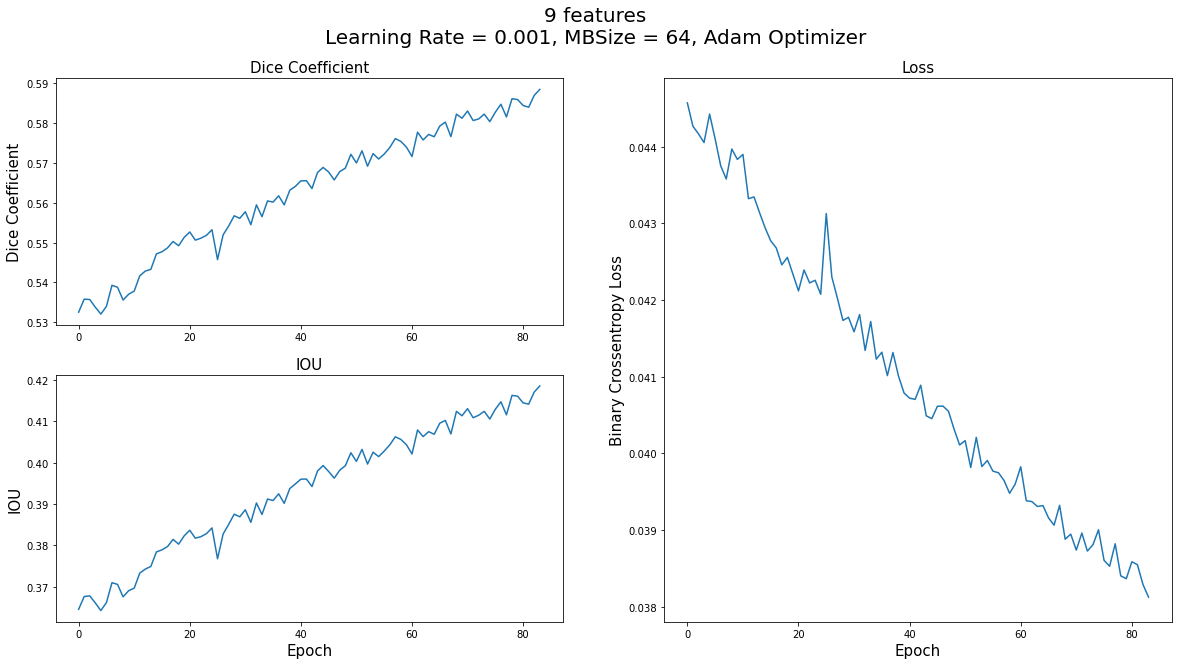

In [23]:
print(history.history.keys())
plt.figure(figsize=(20,10))
plt.subplot(122)
plt.plot(history.history['loss'])
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Binary Crossentropy Loss', fontsize=15)
plt.title('Loss', fontsize=15)
plt.subplot(221)
plt.plot(history.history['dice_coef'])
plt.ylabel('Dice Coefficient', fontsize=15)
plt.title('Dice Coefficient', fontsize=15)
plt.subplot(223)
plt.plot(history.history['iou'])
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('IOU', fontsize=15)
plt.title('IOU', fontsize=15)
plt.suptitle('9 features\nLearning Rate = {}, MBSize = {}, Adam Optimizer'.format(learning_rate, batch_size), fontsize=20)

In [24]:
np.save('V3_9features117-200', history.history)

In [25]:
model.evaluate(X_val_fire9, Y_val_fire)

26/26 [==============================] - 0s 15ms/step - loss: 0.1593 - dice_coef: 0.2526 - iou: 0.1460


[0.15931542217731476, 0.2526339292526245, 0.14599952101707458]

In [26]:
model.save('UnetV3_9features117-200')

2022-05-31 23:47:00.305882: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: UnetV3_9features117-200/assets


In [31]:
def plot_val(i):
    x = X_val_fire9[i,:,:,:]
    x = np.expand_dims(x, axis=0)
    y = model.predict(x)
    y = np.where(y>0.5, 1, 0)
    plt.figure(figsize = (20,6))
    plt.subplot(131)
    plt.imshow(X_val_fire9[i,:,:,8], cmap = 'Wistia')
    plt.title('Previous Day')
    plt.colorbar()
    plt.clim([0,1])
    plt.subplot(132)
    plt.imshow(Y_val_fire[i,:,:], cmap = 'Wistia')
    plt.title('Next Day Fire Mask')
    plt.colorbar()
    plt.clim([0,1])
    plt.subplot(133)
    plt.imshow(y[0,:,:,0], cmap = 'Wistia')
    plt.title('Predicted Fire Mask')
    plt.colorbar()
    plt.clim([0,1])
    plt.clim([0,1])
    plt.suptitle('Previous Day Mask, True Mask v/s Prediction (Val Data) #{}'.format(i), fontsize=15)
    
def plot_train(i):
    x = X_train[i,:,:,:]
    x = np.expand_dims(x, axis=0)
    y = model.predict(x)
    y = np.where(y>0.5, 1, 0)
    plt.figure(figsize = (20,6))
    plt.subplot(131)
    plt.imshow(X_train[i,:,:,11], cmap = 'Wistia')
    plt.title('Previous Day')
    plt.colorbar()
    plt.clim([0,1])
    plt.subplot(132)
    plt.imshow(Y_train[i,:,:], cmap = 'Wistia')
    plt.title('Next Day Fire Mask')
    plt.colorbar()
    plt.subplot(133)
    plt.clim([0,1])
    plt.imshow(y[0,:,:,0], cmap = 'Wistia')
    plt.title('Predicted Fire Mask')
    plt.colorbar()
    plt.clim([0,1])
    plt.suptitle('Previous Day Mask, True Mask v/s Prediction (Training Data) #{}'.format(i), fontsize=15)

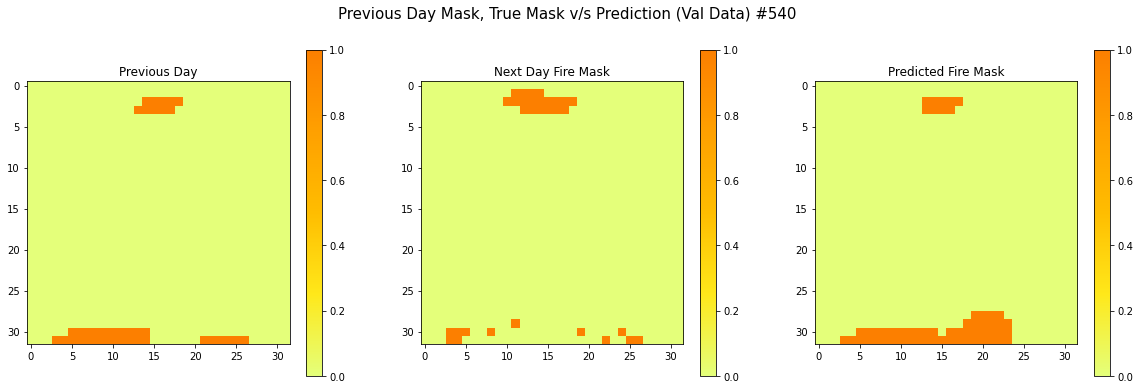

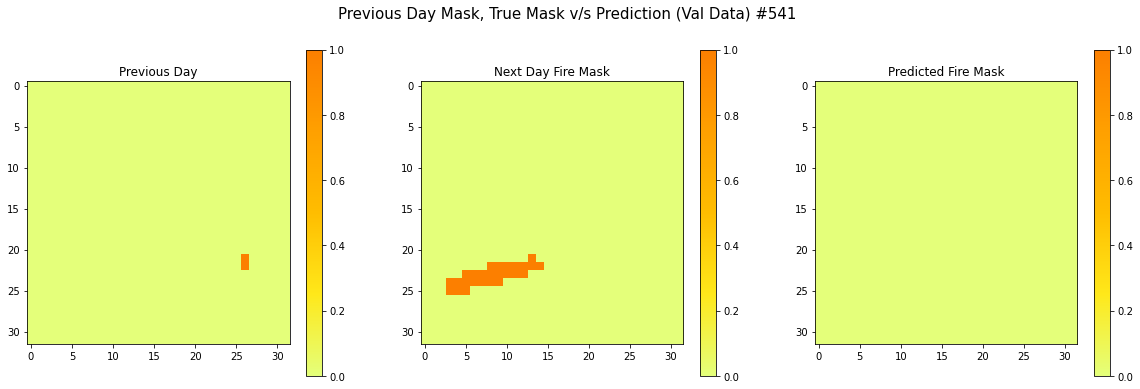

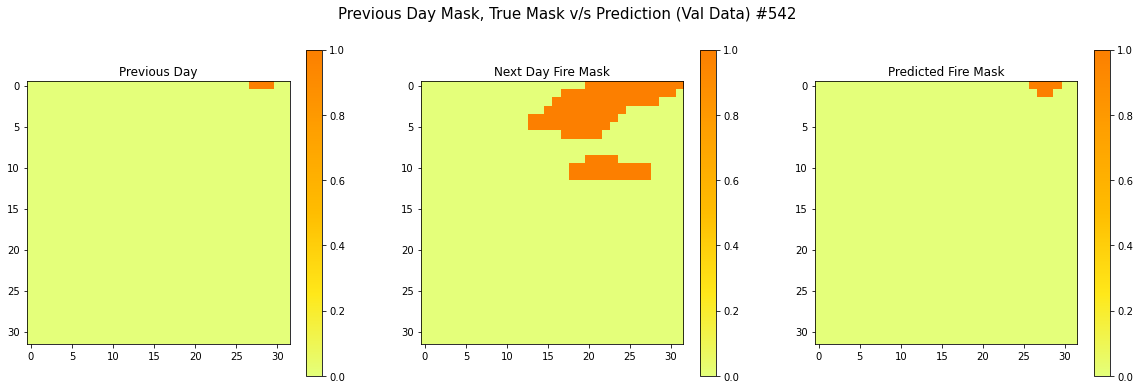

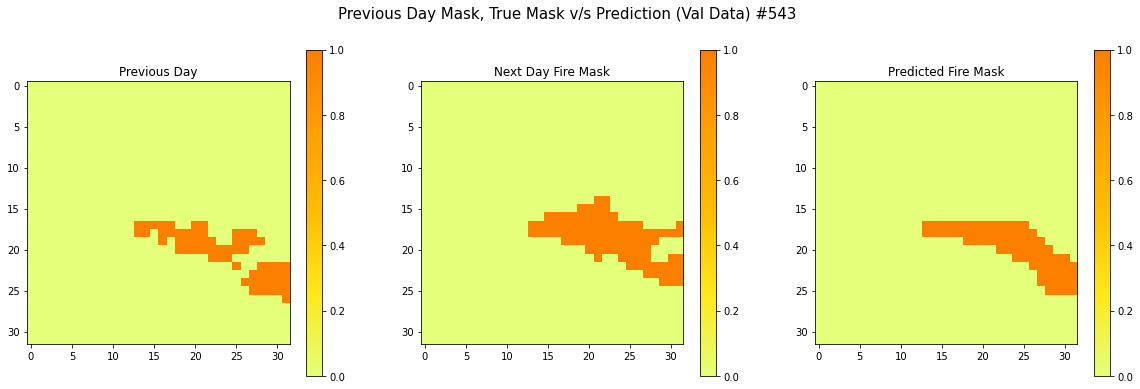

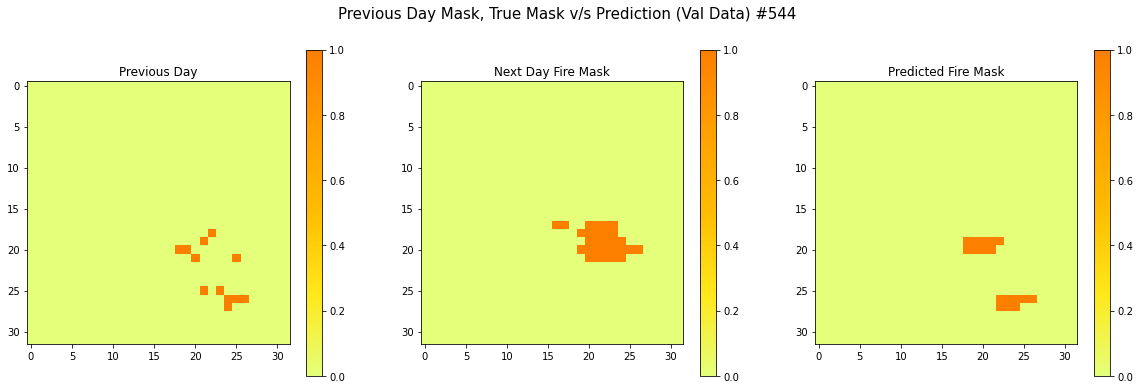

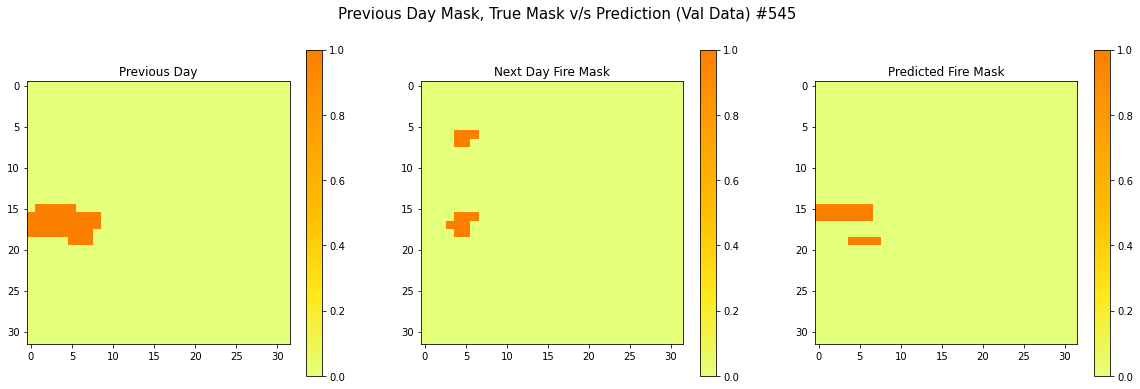

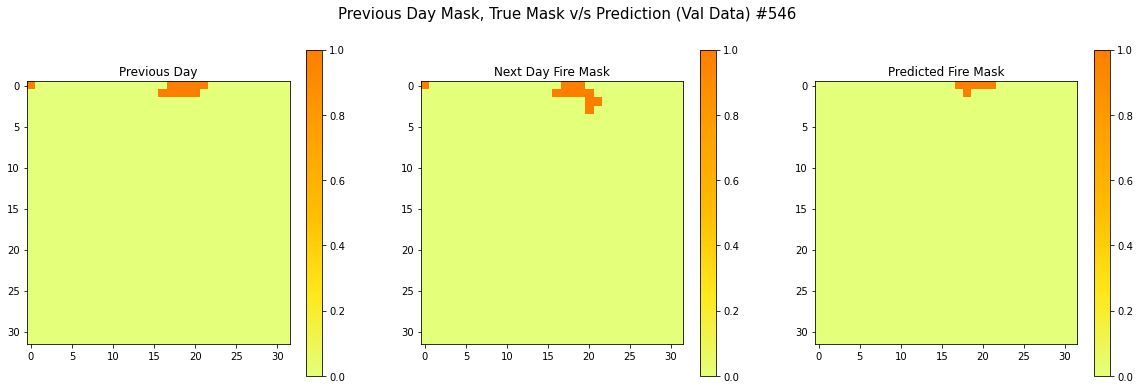

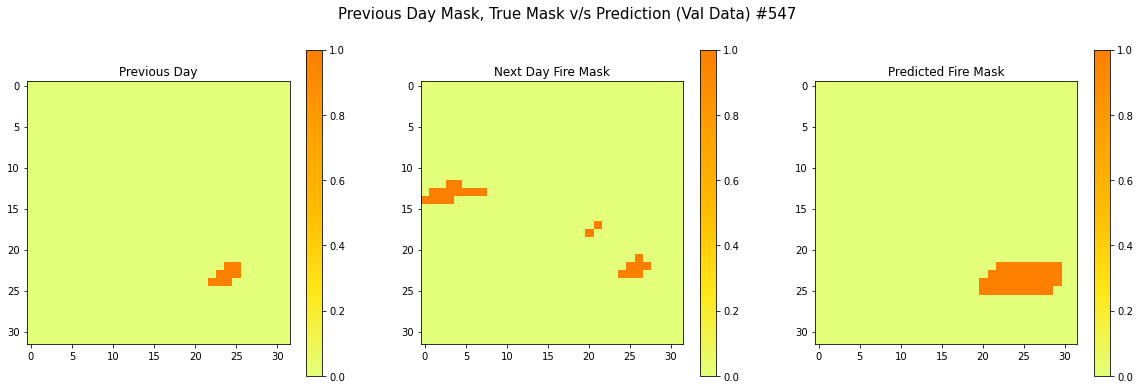

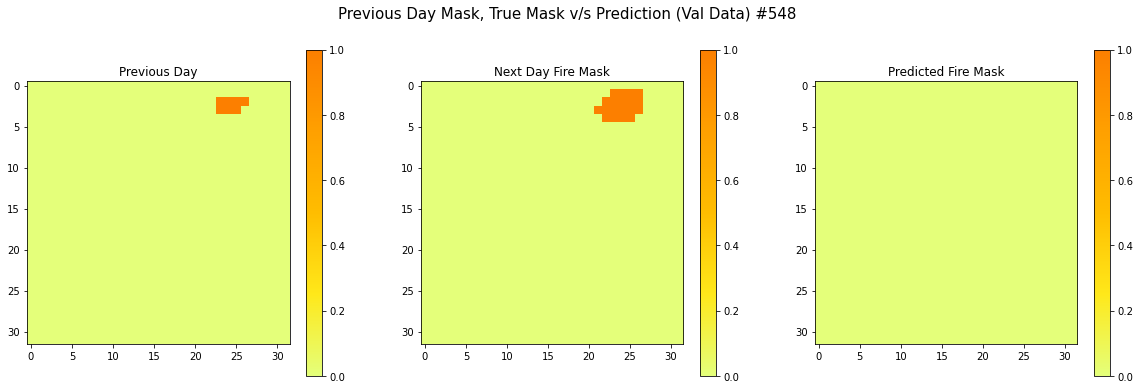

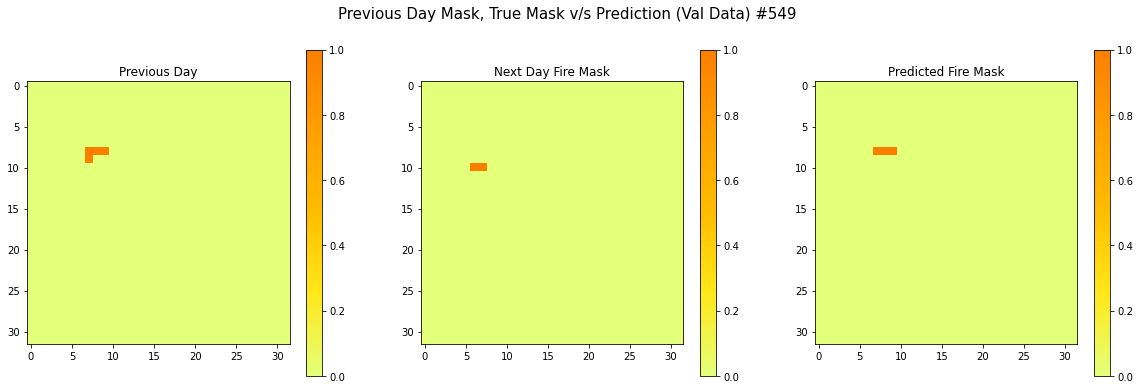

In [34]:
for i in range(540,550):
    plot_val(i)

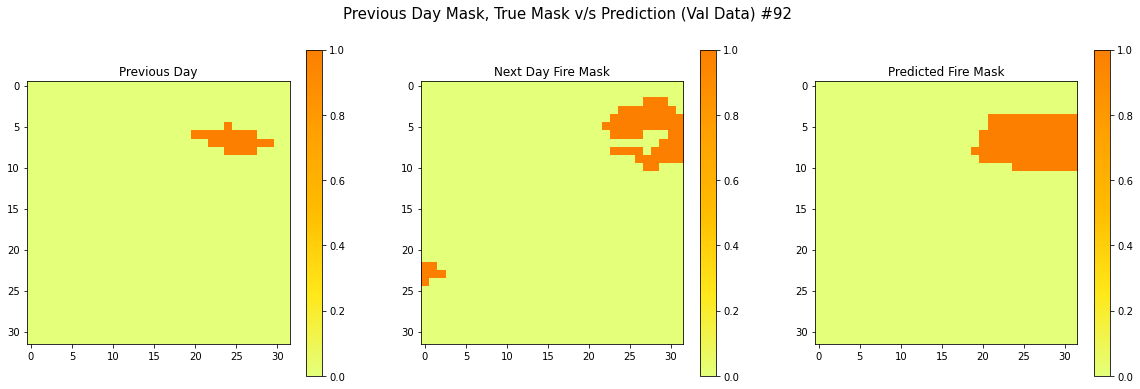

In [33]:
plot_val(92)